In [ ]:
!pip install statannot
!pip install spectral

import io
import os
import scipy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import datasets
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import cohen_kappa_score
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns
from sklearn.neural_network._multilayer_perceptron import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from osgeo import gdal
from skimage import exposure
from sklearn import metrics
from matplotlib import colors
from spectral import*


     |████████████████████████████████| 215kB 3.4MB/s 


In [ ]:
# Define functions
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

#-------------------------------------------------------------------------------
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type

    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)


#-------------------------------------------------------------------------------
# Plot confusion matrix for classification result
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if not title:
    #    if normalize:
    #        title = 'Normalized confusion matrix'
    #    else:
    #        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5.5, 4.9), frameon=True)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=13)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor", fontsize=12)
    
    plt.setp(ax.set_xlabel('Predicted label', fontsize=18))

    plt.setp(ax.get_yticklabels(), rotation=90, ha="center",
             rotation_mode="anchor", fontsize=12)
    
    plt.setp(ax.set_ylabel('True label', fontsize=18))
    
    plt.setp(ax.set_title(title, fontsize=18))

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), size=13,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#-------------------------------------------------------------------------------
# Export classification results to GeoTIFF
from osgeo import gdal,osr
import numpy as np

def save_raster(path, img, prj, geotran, format='GTiff', dtype = gdal.GDT_Float32):
    rows, cols = img.shape
    # Initialize driver & create file
    driver = gdal.GetDriverByName(format)
    dataset_out = driver.Create(path, cols, rows, 1, dtype)
    dataset_out.SetGeoTransform(geotran)
    dataset_out.SetProjection(prj)
    # Write file to disk
    dataset_out.GetRasterBand(1).WriteArray(img.real)
    dataset_out.FlushCache()
    dataset_out=None

#-------------------------------------------------------------------------------
# Define the derivative calculation function
def derivative(f, x, method='central', interval=1):
    '''Compute the difference formula for f'(x) with step size interval.
    Parameters:
    -----------
    f: Function
       Vectorized function of one variable
       
    x: Compute derivative at wavelength x
       method: string - 'forward', 'backward' or 'central'
    
    interval: Step size in difference formula
    '''
    
    if method == 'central':
        return (f(x + interval) - f(x - interval))/(2*interval)
    elif method == 'forward':
        return (f(x + interval) - f(x))/interval
    elif method == 'backward':
        return (f(x) - f(x - interval))/interval
    else:
        raise ValueError("Method must be 'central', 'forward', or 'backward'.")



In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Read reflectance data for derivative calculationplt.style.use('seaborn-dark')
import time
from google.colab import drive
drive.mount('/content/gdrive')
#plt.style.use('classic')
plt.style.use('seaborn-ticks')

start_time = time.process_time()

# Preprocess the data
ref_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/2019_Stress_T0_Deriv_24.csv')
ref_data_ori = ref_data
status = encode_text_index(ref_data, "Status")
x_ml = ref_data.drop(['Sample', 'Status'], axis=1)
y_ml = ref_data['Status']
wavelength = np.arange(440,802,2)

# Scale the data and split the training and test samples
x_ml_tran = x_ml.T
x_ml_tran_scaled = MinMaxScaler().fit_transform(x_ml_tran)
x_ml_scaled = x_ml_tran_scaled.T
x_ml_train, x_ml_test, y_ml_train, y_ml_test = train_test_split(x_ml_scaled, y_ml, test_size = 0.25, random_state = 42, stratify = y_ml)

# Plot the spectral curves
main_font = 22
Sub_font = 18

# Calculate the mean spectral curves
ref_mean = ref_data.groupby("Sample").mean()
wavelength = np.arange(440,800,2)

# Plot the mean spectra
plt_ref_mean = (ref_mean.iloc[0:10, 1:181].values).transpose()
plt_ref_mean = pd.DataFrame(plt_ref_mean, index=wavelength)
plt_ref_mean.plot(figsize=(8, 7), color=sns.set_palette("husl", 10))
plt.title("Mean Spectral Derivative", fontsize=main_font)
plt.xlabel('Wavelength (nm)', fontsize=main_font)
plt.ylabel('Spectral Derivative', fontsize=main_font)
plt.grid(color='grey', linestyle='dotted', linewidth=0.55)
plt.tick_params(direction = 'in', color='black')
plt.xticks(fontsize=Sub_font)
plt.xlim(430, 810)
plt.ylim(0, 0.4)
plt.yticks(fontsize=Sub_font, rotation=90)
plt.legend(loc='upper left', frameon=False, fontsize = Sub_font,
           labels = ['Day 00', 'Day 03','Day 06',
                     'Day 09', 'Day 12', 'Day 15',
                     'Day 18', 'Day 21', 'Day 24',
                     ],
           ncol=2)
plt.savefig('/content/gdrive/My Drive/Mean_Spectral.png', dpi=300)
end_time = time.process_time()
elapsed_time = (end_time - start_time)
print("Processing time:", round(elapsed_time,3), "Secs")

In [ ]:
# Calculate spectral indices used for drought detection
plt.style.use('seaborn-whitegrid')
drive.mount('/content/gdrive')
ref_data_ori = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/2019_Stress_T1_24.csv')

# Calculation of all spectral indices
index_name = ['Date', 'PRI', 'CI_rededge', 'mSR705', 'CARI', 'CCRI', 'ARI', 'NDVI', 'MNLI', 'SR', 'Status_N']
PRI = (ref_data_ori.iloc[:,46] - ref_data_ori.iloc[:,65])/(ref_data_ori.iloc[:,46] + ref_data_ori.iloc[:,65])
CI_rededge = (ref_data_ori.iloc[:,155] + ref_data_ori.iloc[:,133])/ref_data_ori.iloc[:,133]
mSR705 = (ref_data_ori.iloc[:,155] - ref_data_ori.iloc[:,3])/(ref_data_ori.iloc[:,133] - ref_data_ori.iloc[:,3])
CARI = (ref_data_ori.iloc[:,140] - ref_data_ori.iloc[:,40])/ref_data_ori.iloc[:,40]
CCRI = CARI/CI_rededge
ARI = 1/ref_data_ori.iloc[:,55] - 1/ref_data_ori.iloc[:,130]
NDVI = (ref_data_ori.iloc[:,180] - ref_data_ori.iloc[:,120])/(ref_data_ori.iloc[:,180] + ref_data_ori.iloc[:,120])
MNLI = 1.5*((ref_data_ori.iloc[:,180])**2 - ref_data_ori.iloc[:,120])/((ref_data_ori.iloc[:,180])**2 + ref_data_ori.iloc[:,120] + 1.5)
SR = ref_data_ori.iloc[:,155]/ref_data_ori.iloc[:,135]

index_total = pd.DataFrame(
    {'Date': list(ref_data_ori['Status']),
     'PRI': list(PRI),
     'CI_rededge': list(CI_rededge),
     'mSR705': list(mSR705),
     'CARI': list(CARI),
     'CCRI': list(CCRI),
     'ARI': list(ARI),
     'NDVI': list(NDVI),
     'MNLI': list(MNLI),
     'SR': list(SR),
     'Status_N': list(ref_data_ori['Status'])},
     columns = index_name
     )

day_mean = list(np.arange(0,30,3))
index_mean = index_total.groupby('Date').mean()
index_std = index_total.groupby('Date').std()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Train individual 2D MLP classification model for spectral indices
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from google.colab import drive
from sklearn import svm
import csv
import pickle
plt.style.use('seaborn-dark')

status_N = encode_text_index(index_total, "Status_N")
x_index = index_total.drop(['Date', 'Status_N'], axis=1)
y_index = index_total['Status_N']
x_index_train, x_index_test, y_index_train, y_index_test = train_test_split(x_index, y_index, test_size = 0.25, random_state = 42, stratify = y_index)
x_index

#Prepare inputs for index models
index_list = ['PRI', 'CI_rededge', 'mSR705', 'CARI', 'CCRI', 'ARI', 'NDVI', 'MNLI', 'SR']
scaler_list = ['PRI', 'CI_rededge', 'mSR705', 'CARI', 'CCRI', 'ARI', 'NDVI', 'MNLI', 'SR']
for model in index_list:
  index_name = ['Date', 'PRI', 'CI_rededge', 'mSR705', 'CARI', 'CCRI', 'ARI', 'NDVI', 'MNLI', 'SR', 'Status_N']
  index_name.remove(model)
  status_N = encode_text_index(index_total, "Status_N")
  x_index = index_total.drop(index_name, axis=1)
  y_index = index_total['Status_N']

  # Scale the data and split the training and test samples
  x_mesh_train, x_mesh_test, y_mesh_train, y_mesh_test = train_test_split(x_index, y_index, test_size = 0.25, random_state = 42, stratify = y_index)
  
  start_time = time.time()
  # Setup parameters for MLP model tuning
  mlp_parameters = {
    'hidden_layer_sizes': [(300,300), (200,200), (150,150), (100,100), (50,50), (30,30)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
  }

  mlp_mesh_grid = RandomizedSearchCV(estimator = MLPClassifier(max_iter=1000),
                              param_distributions=mlp_parameters, cv = 10, verbose = 1, n_jobs=-1)

  mlp_mesh_grid.fit(x_mesh_train, y_mesh_train)

  means = mlp_mesh_grid.cv_results_['mean_test_score']
  stds = mlp_mesh_grid.cv_results_['std_test_score']

  # Save the trained MLP model as a pickle file
  drive.mount('/content/gdrive')
  path = F'/content/gdrive/My Drive/' + 'mlp_' + model + '_T1_24.pkl'
  joblib.dump(mlp_mesh_grid, open(path, 'wb'))

  end_time = time.time()
  elapsed_time = (end_time - start_time)
  print("Processing time:", round(elapsed_time,3), "Secs")

  # Load the model and perform classification
  mesh_classifier =  joblib.load(open(path, 'rb'))

  y_mesh_pred = mesh_classifier.predict(x_mesh_test)

  kappa_mlp = cohen_kappa_score(y_mesh_test, y_mesh_pred)
  Overall_acc = accuracy_score(y_mesh_test, y_mesh_pred)
  print("Overall Accuracy:", round(Overall_acc*100, 3))
  print("Kappa Coefficient:", round(kappa_mlp, 3))

  #Plot normalized confusion matrix
  np.set_printoptions(precision=2)
  plot_confusion_matrix(y_mesh_test, y_mesh_pred, classes=status, normalize=True,
                      title='Normalized matrix - ' + model)

  plt.savefig('/content/gdrive/My Drive/mlp_' + model + '_matrix_T1_24.png', dpi=300)
  plt.show()

  # Save runtime and accuracy to CSV
  with open('/content/gdrive/My Drive/mlp_' + model + '_accuracy_T1_24.txt', 'a', newline='') as txtfile:
    #row_write = csv.writer(csvfile, delimiter=' ')
    txtfile.write('Runtime: ' + str(round(elapsed_time, 0)) + '\n')
    txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
    txtfile.write('Kappa Coefficient: ' + str(round(kappa_mlp, 3)))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

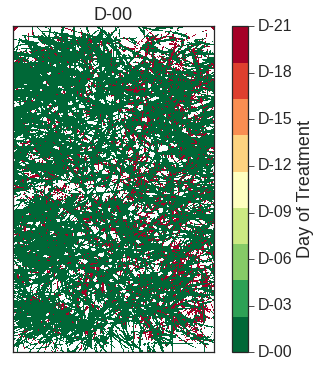

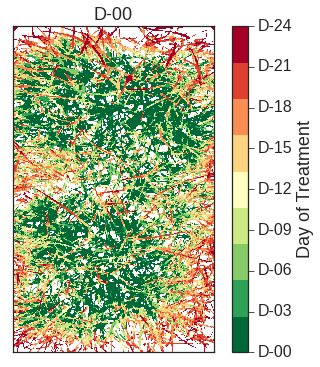

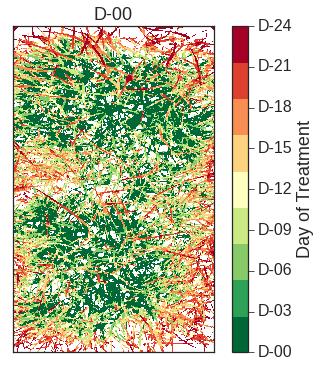

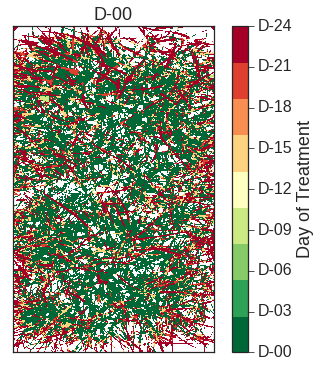

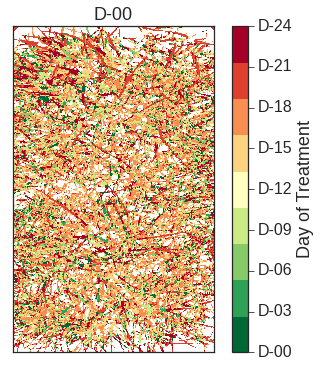

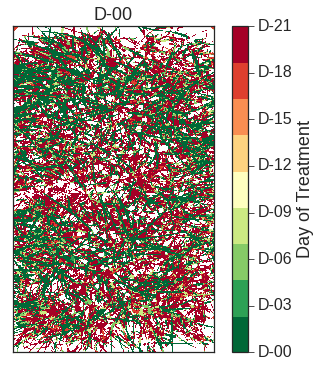

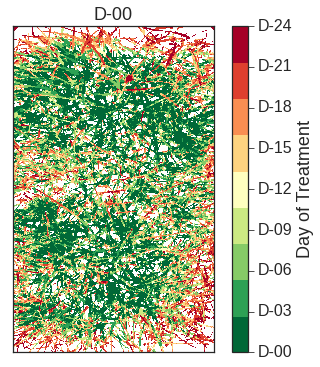

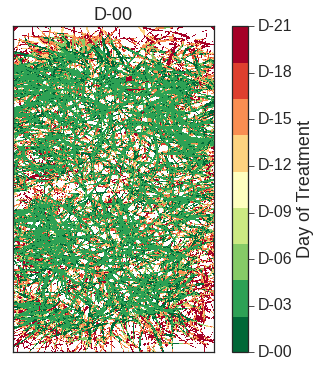

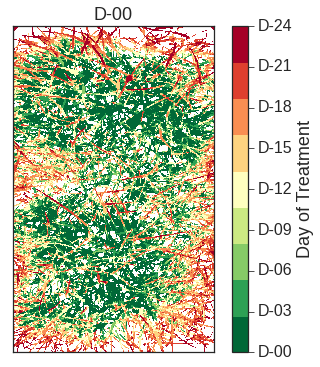

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

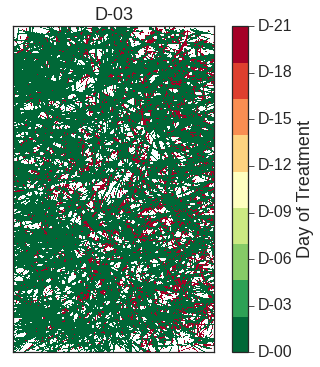

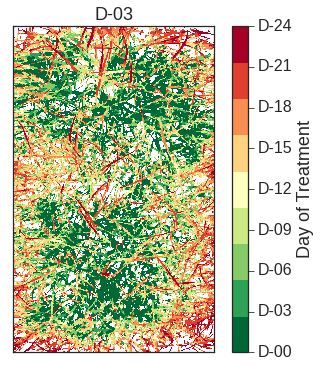

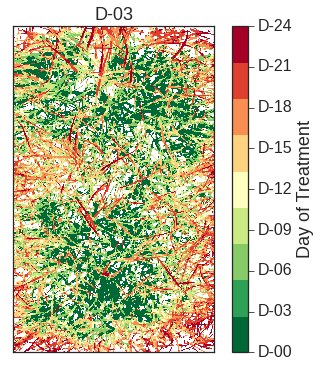

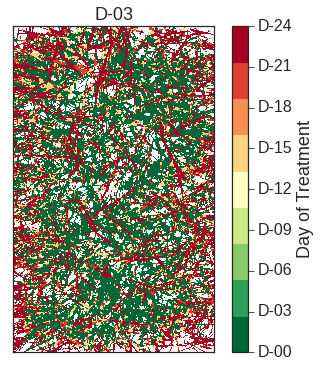

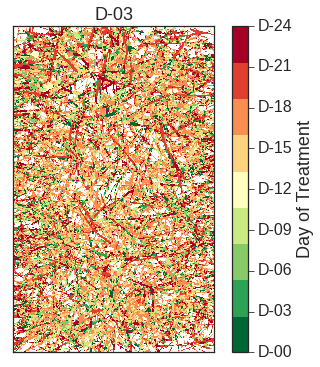

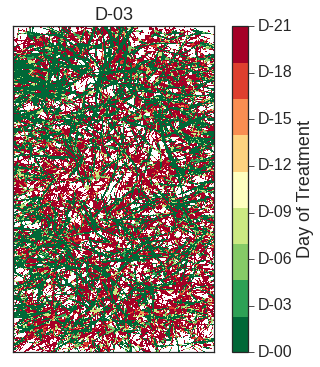

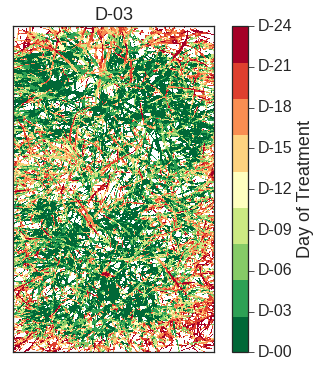

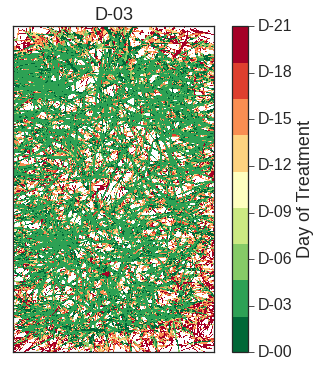

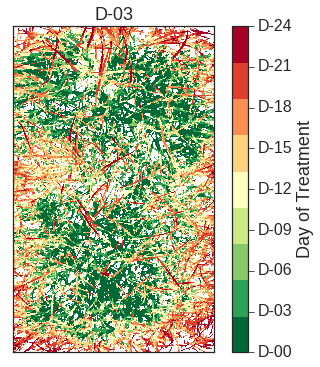

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

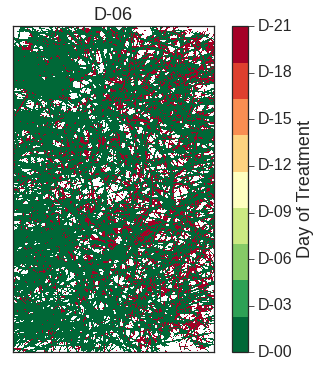

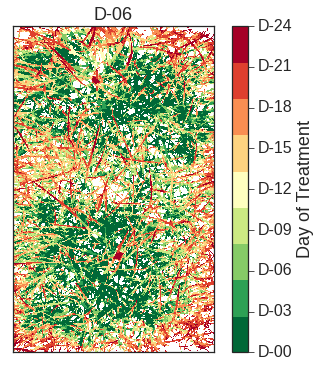

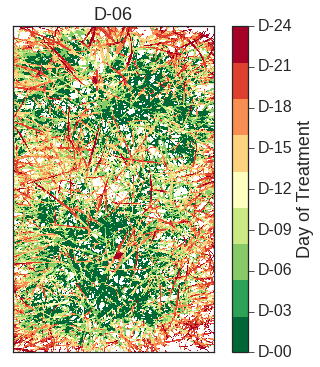

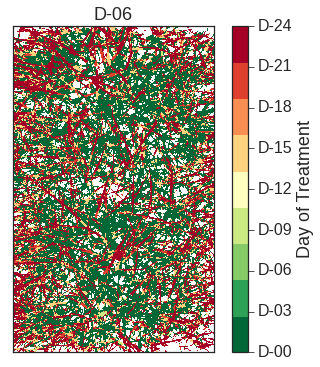

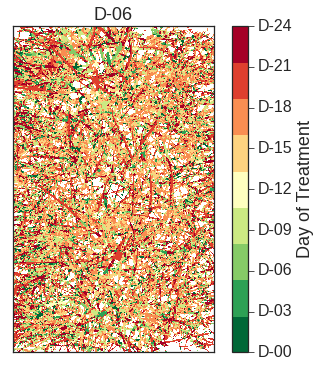

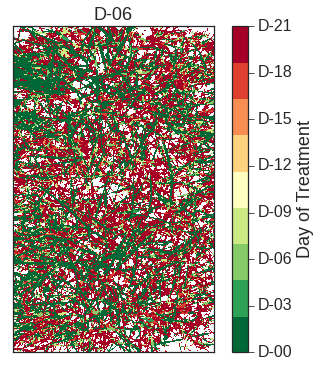

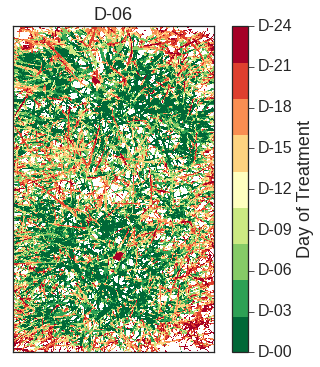

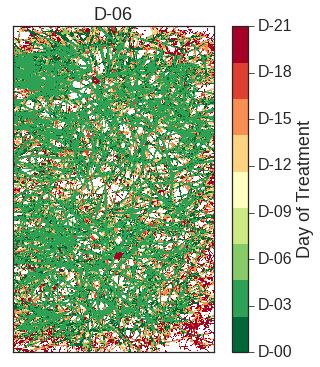

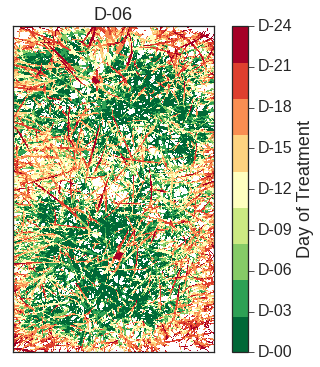

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

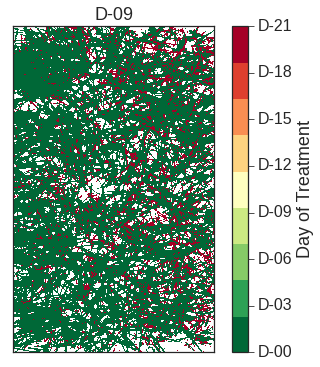

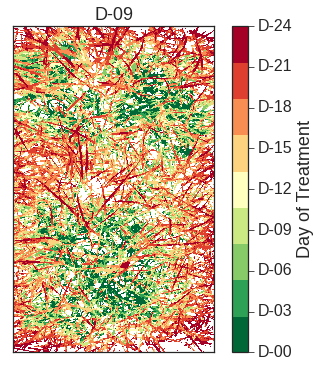

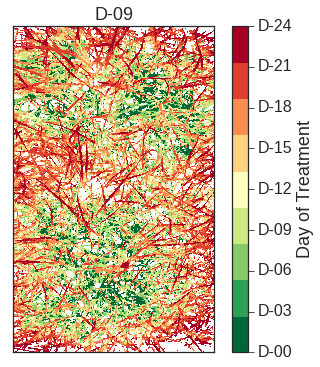

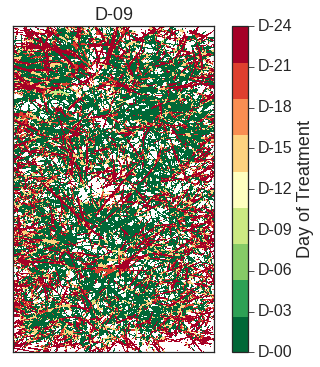

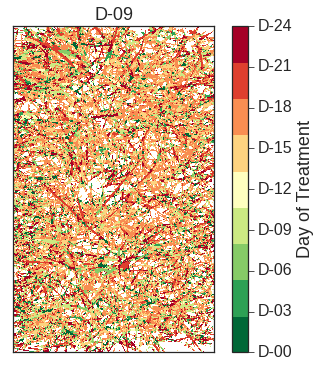

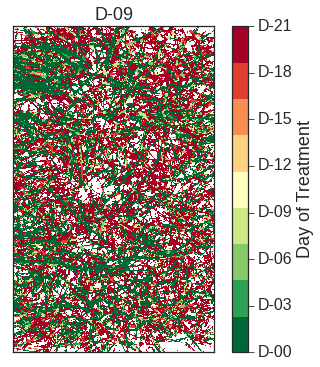

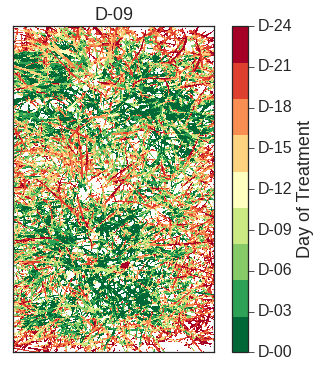

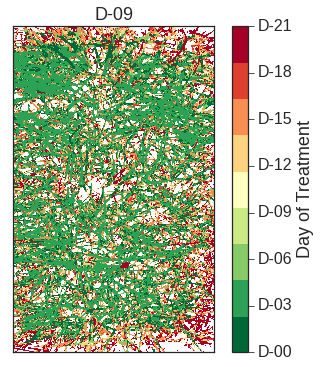

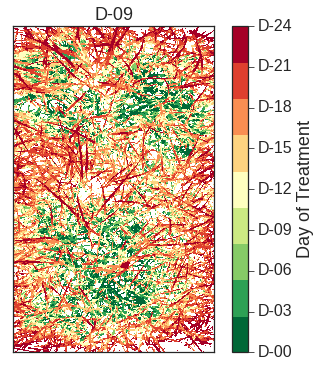

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

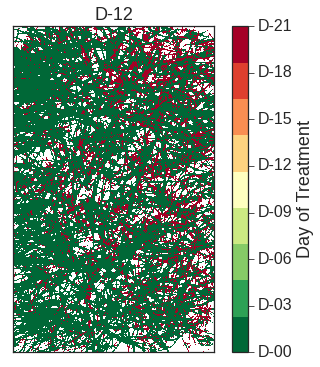

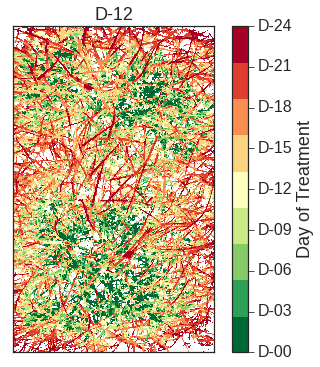

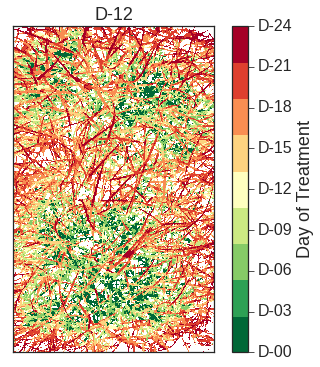

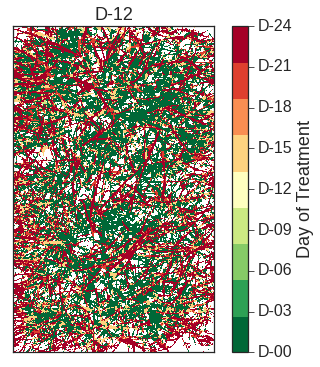

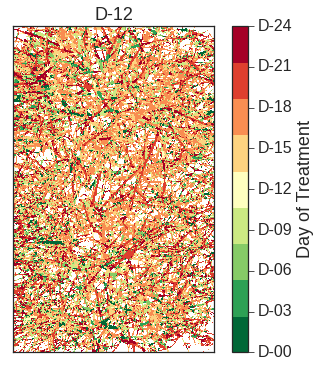

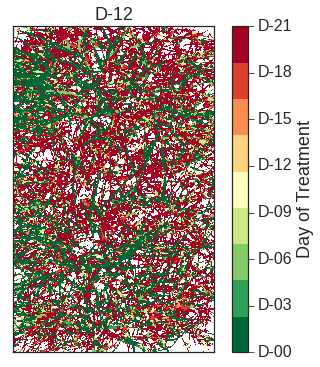

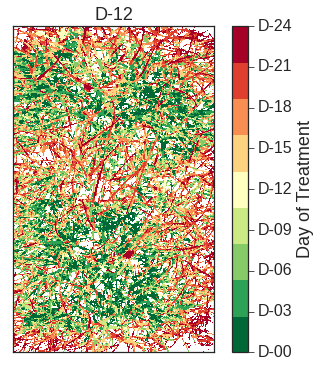

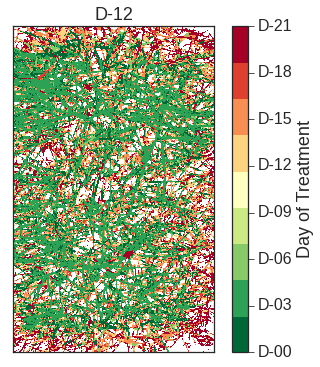

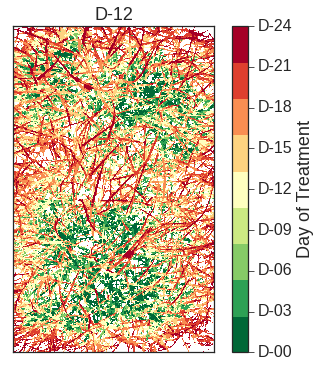

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

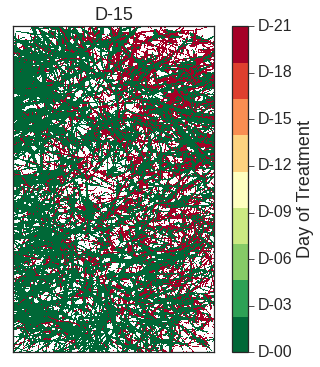

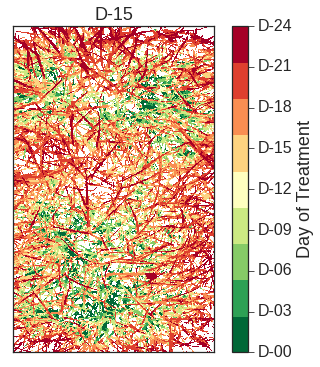

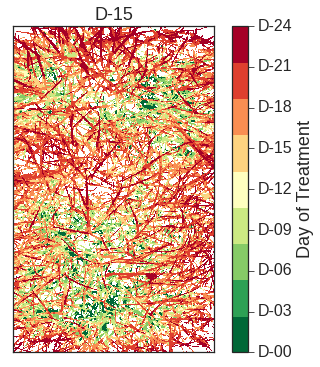

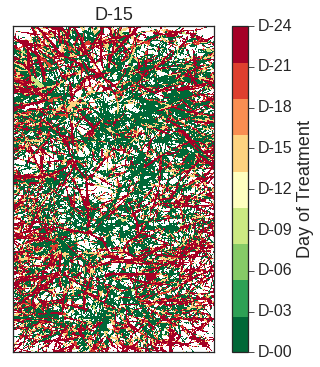

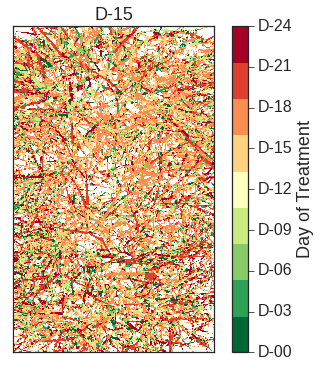

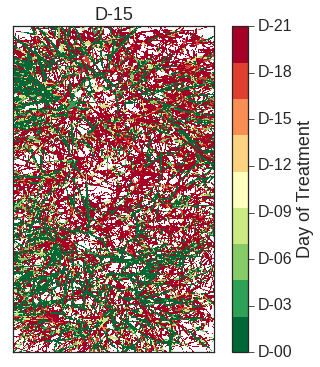

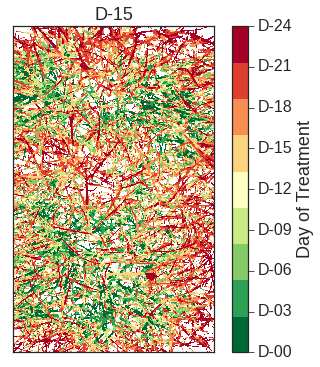

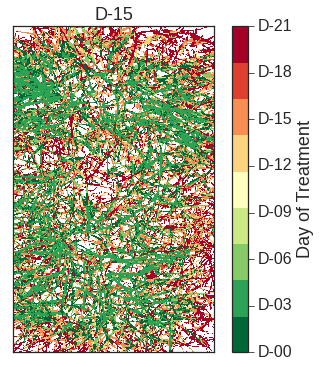

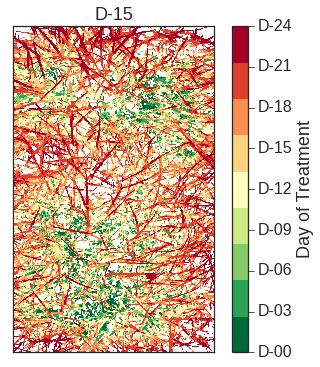

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

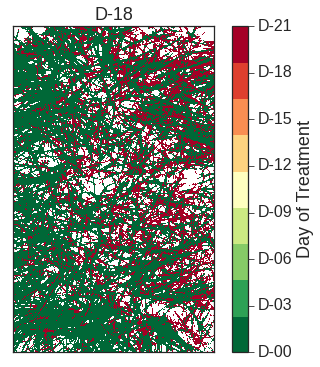

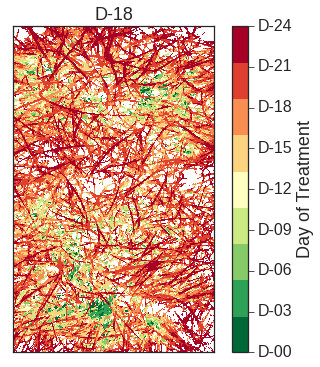

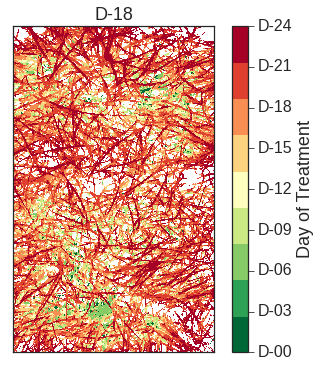

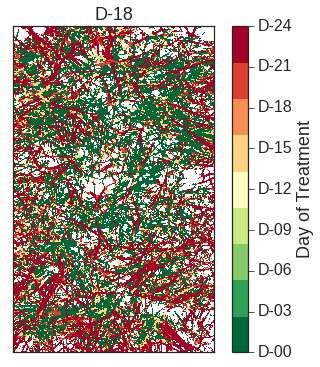

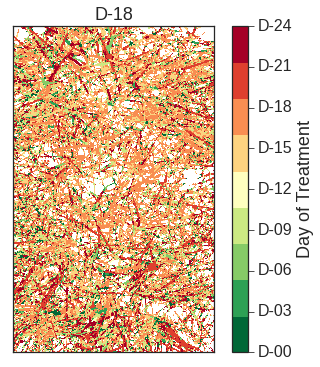

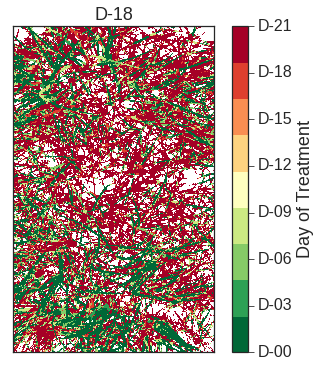

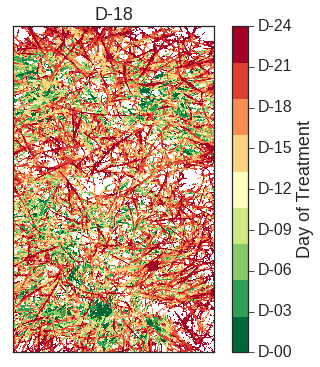

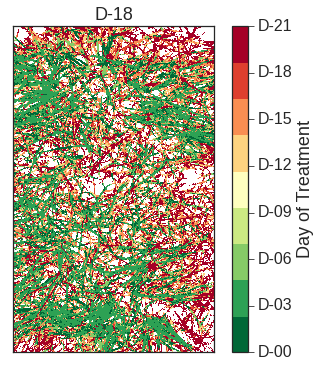

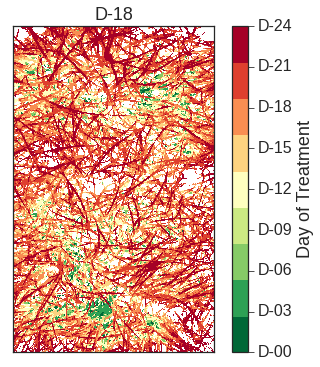

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

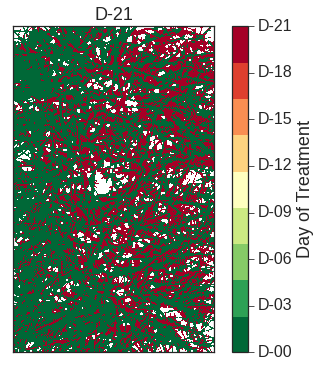

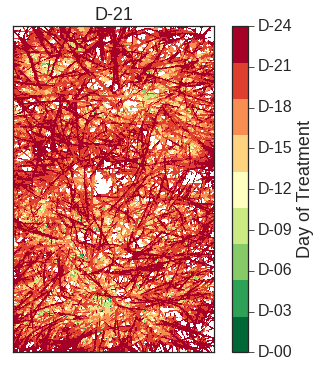

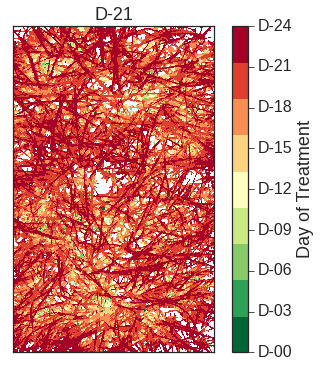

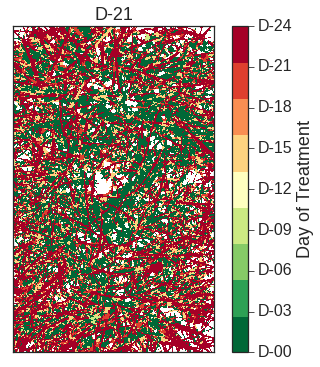

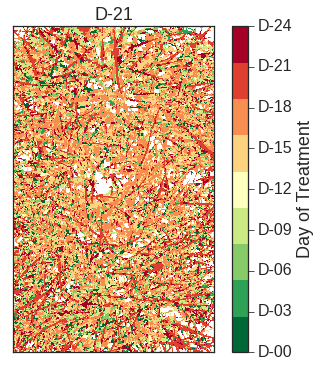

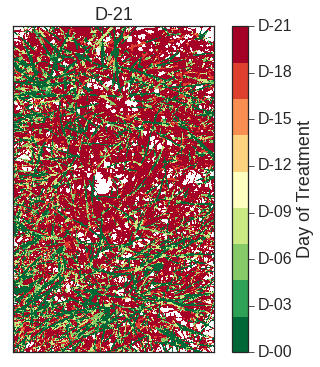

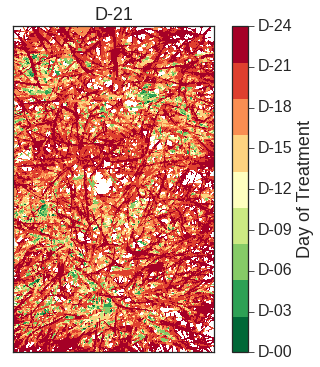

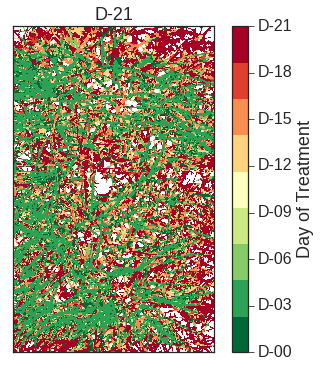

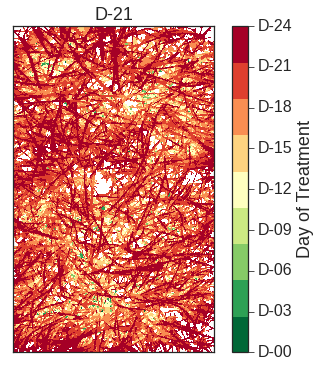

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

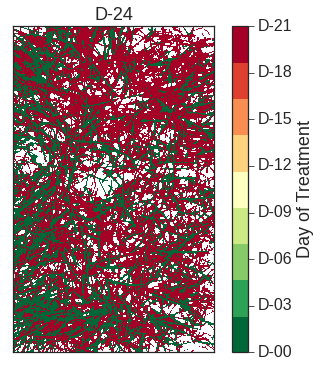

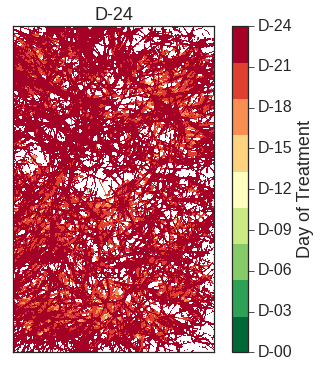

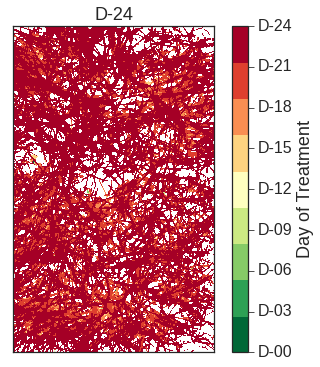

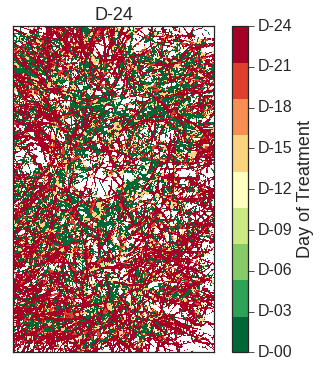

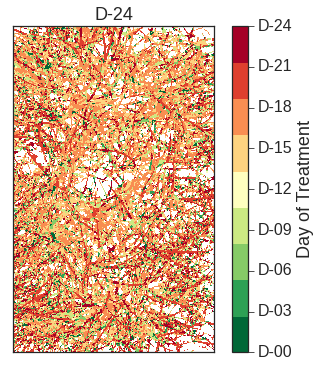

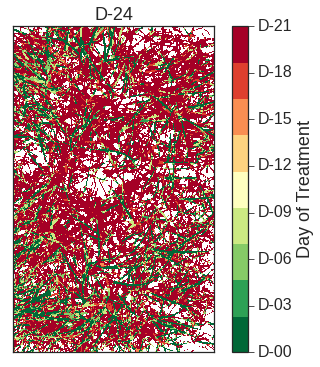

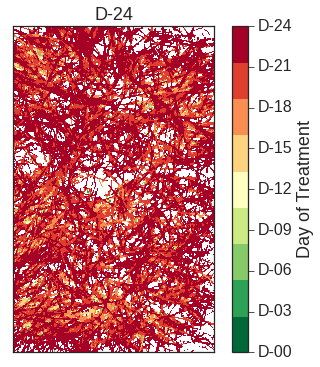

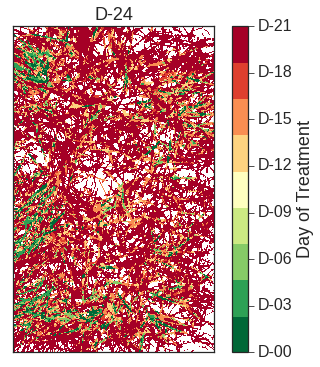

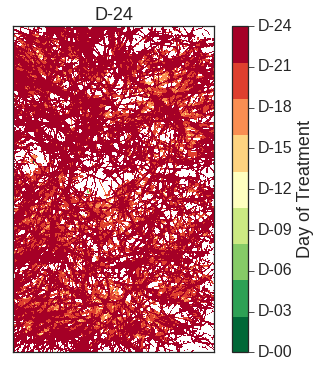

In [ ]:
# Classify each individual index images
import os
import gdal
import pickle
from pylab import*
import pandas as pd
from sklearn.externals import joblib
from google.colab import drive
plt.style.use('seaborn-ticks')
drive.mount('/content/gdrive')

# Load original images
day_list = ['D-00', 'D-03', 'D-06', 'D-09', 'D-12', 'D-15', 'D-18', 'D-21', 'D-24']
date_list = ['20190617', '20190620', '20190623', '20190626', '20190630', '20190704', '20190708', '20190712', '20190718']
mask_list = [0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.15]
for treat_day, treat_date, mask_val in zip(day_list, date_list, mask_list):
  img_ori_name = '/content/gdrive/My Drive/T01_' + treat_date + '_Ref_Sm_Res_Sub_440-800_segmentation.tif'
  
  raster_dataset = gdal.Open(img_ori_name, gdal.GA_ReadOnly)
  geo_transform = raster_dataset.GetGeoTransform()
  proj = raster_dataset.GetProjectionRef()
  n_bands = raster_dataset.RasterCount
  hsi_img = np.moveaxis(raster_dataset.ReadAsArray()[:251], 0, -1)

  # Calculate spectral indices
  PRI = (hsi_img[:,:,46] - hsi_img[:,:,65])/(hsi_img[:,:,46] + hsi_img[:,:,65])
  PRI = np.where(np.isnan(PRI), 0, PRI)
  CI_rededge = (hsi_img[:,:,155] + hsi_img[:,:,133])/(hsi_img[:,:,133])
  CI_rededge = np.where(np.isnan(CI_rededge), 0, CI_rededge)
  mSR705 = (hsi_img[:,:,155] - hsi_img[:,:,3])/(hsi_img[:,:,133] - hsi_img[:,:,3])
  mSR705 = np.where(np.isnan(mSR705), 0, mSR705)
  CARI = (hsi_img[:,:,140] - hsi_img[:,:,40])/(hsi_img[:,:,40])
  CARI = np.where(np.isnan(CARI), 0, CARI)
  CCRI = (CARI/CI_rededge)
  CCRI = np.where(np.isnan(CCRI), 0, CCRI)
  ARI = 1/hsi_img[:,:,55] - 1/hsi_img[:,:,130]
  ARI = np.where(np.isnan(ARI), 0, ARI)
  NDVI = (hsi_img[:,:,180] - hsi_img[:,:,120])/(hsi_img[:,:,180] + hsi_img[:,:,120])
  NDVI = np.where(np.isnan(NDVI), 0, NDVI)
  MNLI = 1.5*((hsi_img[:,:,180])**2 - hsi_img[:,:,120])/((hsi_img[:,:,180])**2 + hsi_img[:,:,120] + 1.5)
  MNLI = np.where(np.isnan(MNLI), 0, MNLI)
  SR = hsi_img[:,:,155]/hsi_img[:,:,135]
  SR = np.where(np.isnan(SR), 0, SR)
  Combined_index = np.dstack([PRI, CI_rededge, mSR705, CARI, CCRI, ARI, NDVI, MNLI, SR])

  index_name = ['PRI', 'CI_rededge', 'mSR705', 'CARI', 'CCRI', 'ARI', 'NDVI', 'MNLI', 'SR']
  index_list = [PRI, CI_rededge, mSR705, CARI, CCRI, ARI, NDVI, MNLI, SR]
  for img_name, img_index in zip(index_name, index_list):
    # Load the model and perform classification
    path = F'/content/gdrive/My Drive/' + 'mlp_' + img_name + '_T0_24.pkl'
    mesh_classifier =  joblib.load(open(path, 'rb'))
    n_row, n_col = img_index.shape
    classified_index = np.empty(shape=(n_row, n_col), dtype='uint8')
    for i in np.arange(n_row):
      for j in np.arange(n_col):
        classified_index[i,j] = mesh_classifier.predict((img_index[i,j]).reshape(-1, 1))

    # Plot the classified image
    classified_index_mask = classified_index
    classified_index_mask = np.ma.masked_array(classified_index_mask, mask=(hsi_img[:, :, 180] <= mask_val))

    # Plot classified image
    color_map = plt.cm.get_cmap('RdYlGn', 9)
    cmap = color_map.reversed()
    class_name = ['D-00', 'D-03', 'D-06', 'D-09', 'D-12', 'D-15', 'D-18', 'D-21', 'D-24']
    plt.figure(figsize=(6.5, 6))
    img1 = plt.imshow(classified_index_mask, interpolation='none', cmap=cmap) #plt.cm.Greens, plt.cm.YlGn, plt.cm.get_cmap('Greens', 9)
    plt.title(treat_day, fontsize=18)
    cbar = plt.colorbar(img1)
    cbar.set_label(label="Day of Treatment", size=18)
    cbar.ax.tick_params(labelsize=16, rotation=0)
    cbar.ax.set_yticklabels(labels=class_name, va="center")
    plt.xticks(ticks=[], labels=None)
    plt.yticks(ticks=[], labels=None)
    plt.grid(b=None)
    savefile = '/content/gdrive/My Drive/T0_img_' + img_name + '_mlp_' + treat_day
    plt.savefig(savefile + '.png', dpi=150)
    plt.show()

    # Export classification results to GeoTIFF
    save_tiff_file = savefile + '.tif'
    prj = raster_dataset.GetProjection()
    geotran = raster_dataset.GetGeoTransform()
    save_raster(path=save_tiff_file, img = classified_index_mask, prj=prj, geotran=geotran, format='GTiff', dtype=gdal.GDT_Byte)


In [ ]:
# MLP Model training for the combined indices (combine all indices in classification)
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from google.colab import drive
from sklearn import svm
import csv
import pickle
plt.style.use('seaborn-dark')

treat = 'T1'

#Prepare inputs for index models
status_N = encode_text_index(index_total, "Status_N")
x_index = index_total.drop(['Date', 'Status_N'], axis=1)
y_index = index_total['Status_N']

# Split the training and test samples and scale the data
x_train, x_test, y_train, y_test = train_test_split(x_index, y_index, test_size = 0.25, random_state = 42, stratify = y_index)
scaler_mesh = MinMaxScaler()
x_mesh_train = scaler_mesh.fit_transform(x_train)
x_mesh_test = scaler_mesh.transform(x_test)
y_mesh_train = y_train
y_mesh_test = y_test

start_time = time.time()
# Setup parameters for MLP model tuning
mlp_parameters = {
  'hidden_layer_sizes': [(300,300), (200,200), (150,150), (100,100), (50,50), (30,30)],
  'activation': ['identity', 'logistic', 'tanh', 'relu'],
  'solver': ['lbfgs', 'sgd', 'adam'],
  'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
  'learning_rate': ['constant','adaptive', 'invscaling'],
}

mlp_mesh_grid = RandomizedSearchCV(estimator = MLPClassifier(max_iter=1000),
                            param_distributions=mlp_parameters, cv = 10, verbose = 1, n_jobs=-1)

mlp_mesh_grid.fit(x_mesh_train, y_mesh_train)

means = mlp_mesh_grid.cv_results_['mean_test_score']
stds = mlp_mesh_grid.cv_results_['std_test_score']

# Save the trained MLP model as a pickle file
drive.mount('/content/gdrive')
path = F'/content/gdrive/My Drive/mlp_combined_index_' + treat + '_24.pkl'
joblib.dump(mlp_mesh_grid, open(path, 'wb'))

end_time = time.time()
elapsed_time = (end_time - start_time)
print("Processing time:", round(elapsed_time,3), "Secs")

# Load the model and perform classification
mesh_classifier =  joblib.load(open(path, 'rb'))

y_mesh_pred = mesh_classifier.predict(x_mesh_test)

kappa_mlp = cohen_kappa_score(y_mesh_test, y_mesh_pred)
Overall_acc = accuracy_score(y_mesh_test, y_mesh_pred)
print("Overall Accuracy:", round(Overall_acc*100, 3))
print("Kappa Coefficient:", round(kappa_mlp, 3))

#Plot normalized confusion matrix
np.set_printoptions(precision=2)
plot_confusion_matrix(y_mesh_test, y_mesh_pred, classes=status, normalize=True,
                    title='Normalized matrix - ' + 'Combined index')

plt.savefig('/content/gdrive/My Drive/mlp_combined_index_matrix_' + treat + '_24.png', dpi=300)
plt.show()

# Save runtime and accuracy to CSV
with open('/content/gdrive/My Drive/mlp_combined_index_accuracy_' + treat + '_24.txt', 'a', newline='') as txtfile:
  #row_write = csv.writer(csvfile, delimiter=' ')
  txtfile.write('Runtime: ' + str(round(elapsed_time, 0)) + '\n')
  txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
  txtfile.write('Kappa Coefficient: ' + str(round(kappa_mlp, 3)))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

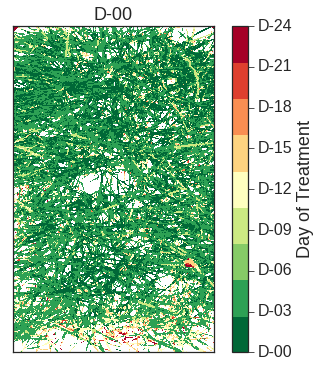

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

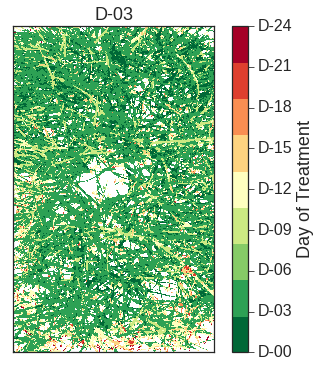

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

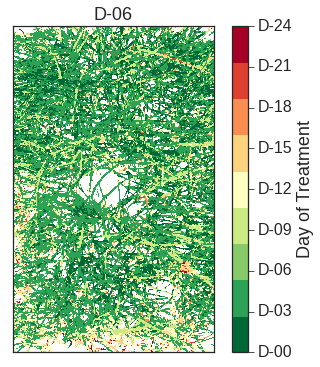

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

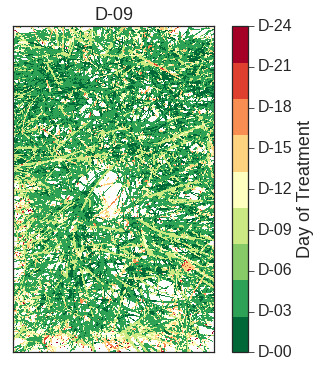

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

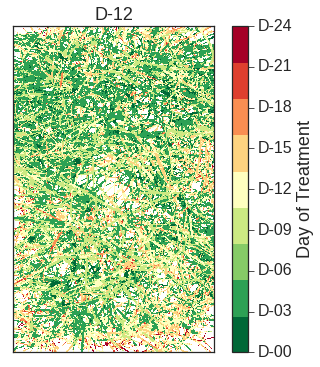

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

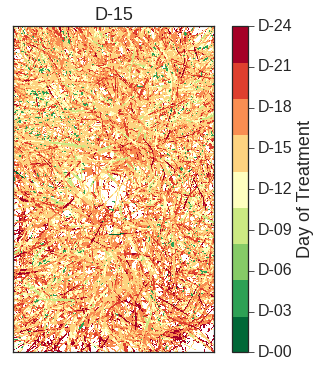

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

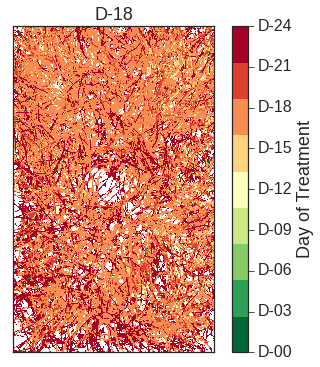

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

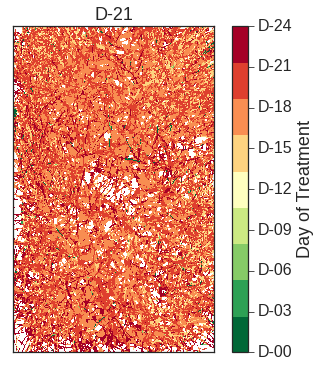

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/d

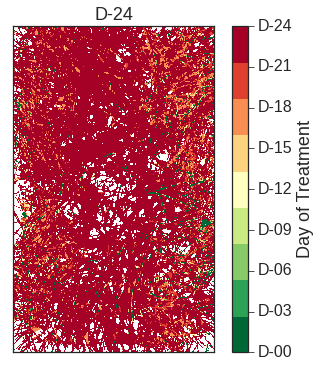

In [ ]:
# Classify combined index images (combine all indices in classification)
import os
import gdal
import pickle
from pylab import*
import pandas as pd
from sklearn.externals import joblib
from google.colab import drive
drive.mount('/content/gdrive')
plt.style.use('seaborn-ticks')

day_list = ['D-00', 'D-03', 'D-06', 'D-09', 'D-12', 'D-15', 'D-18', 'D-21', 'D-24']
date_list = ['20190617', '20190620', '20190623', '20190626', '20190630', '20190704', '20190708', '20190712', '20190718']
mask_list = [0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.15]
for treat_day, treat_date, mask_val in zip(day_list, date_list, mask_list):
  img_ori_name = '/content/gdrive/My Drive/T01_' + treat_date + '_Ref_Sm_Res_Sub_440-800_segmentation.tif'
  
  raster_dataset = gdal.Open(img_ori_name, gdal.GA_ReadOnly)
  geo_transform = raster_dataset.GetGeoTransform()
  proj = raster_dataset.GetProjectionRef()
  n_bands = raster_dataset.RasterCount
  hsi_img = np.moveaxis(raster_dataset.ReadAsArray()[:251], 0, -1)

  # Calculate spectral indices
  PRI = (hsi_img[:,:,46] - hsi_img[:,:,65])/(hsi_img[:,:,46] + hsi_img[:,:,65])
  PRI = np.where(np.isnan(PRI), 0, PRI)
  CI_rededge = (hsi_img[:,:,155] + hsi_img[:,:,133])/(hsi_img[:,:,133])
  CI_rededge = np.where(np.isnan(CI_rededge), 0, CI_rededge)
  mSR705 = (hsi_img[:,:,155] - hsi_img[:,:,3])/(hsi_img[:,:,133] - hsi_img[:,:,3])
  mSR705 = np.where(np.isnan(mSR705), 0, mSR705)
  CARI = (hsi_img[:,:,140] - hsi_img[:,:,40])/(hsi_img[:,:,40])
  CARI = np.where(np.isnan(CARI), 0, CARI)
  CCRI = (CARI/CI_rededge)
  CCRI = np.where(np.isnan(CCRI), 0, CCRI)
  ARI = 1/hsi_img[:,:,55] - 1/hsi_img[:,:,130]
  ARI = np.where(np.isnan(ARI), 0, ARI)
  NDVI = (hsi_img[:,:,180] - hsi_img[:,:,120])/(hsi_img[:,:,180] + hsi_img[:,:,120])
  NDVI = np.where(np.isnan(NDVI), 0, NDVI)
  MNLI = 1.5*((hsi_img[:,:,180])**2 - hsi_img[:,:,120])/((hsi_img[:,:,180])**2 + hsi_img[:,:,120] + 1.5)
  MNLI = np.where(np.isnan(MNLI), 0, MNLI)
  SR = hsi_img[:,:,155]/hsi_img[:,:,135]
  SR = np.where(np.isnan(SR), 0, SR)
  Combined_index = np.dstack([PRI, CI_rededge, mSR705, CARI, CCRI, ARI, NDVI, MNLI, SR])

  # Load models and classify images
  path = F'/content/gdrive/My Drive/mlp_combined_index_T0_24.pkl'
  mesh_classifier =  joblib.load(open(path, 'rb'))
  n_row, n_col, n_band = Combined_index.shape
  classified_index = np.empty(shape=(n_row, n_col), dtype='uint8')
  for i in np.arange(n_row):
    for j in np.arange(n_col):
      classified_index[i,j] = mesh_classifier.predict(scaler_mesh.transform((Combined_index[i,j,:]).reshape(1,-1)))

  # Plot the classified image
  classified_index_mask = classified_index
  classified_index_mask = np.ma.masked_array(classified_index_mask, mask=(hsi_img[:, :, 180] <= mask_val))

  # Plot classified image
  color_map = plt.cm.get_cmap('RdYlGn', 9)
  cmap = color_map.reversed()
  class_name = ['D-00', 'D-03', 'D-06', 'D-09', 'D-12', 'D-15', 'D-18', 'D-21', 'D-24']
  plt.figure(figsize=(6.5, 6))
  img1 = plt.imshow(classified_index_mask, interpolation='none', cmap=cmap) #plt.cm.Greens, plt.cm.YlGn, plt.cm.get_cmap('Greens', 9)
  plt.title(treat_day, fontsize=18)
  cbar = plt.colorbar(img1)
  cbar.set_label(label="Day of Treatment", size=18)
  cbar.ax.tick_params(labelsize=16, rotation=0)
  cbar.ax.set_yticklabels(labels=class_name, va="center")
  plt.xticks(ticks=[], labels=None)
  plt.yticks(ticks=[], labels=None)
  plt.grid(b=None)
  savefile = '/content/gdrive/My Drive/T0_img_combined_index_mlp_' + treat_day
  plt.savefig(savefile + '.png', dpi=150)
  plt.show()

  # Export classification results to GeoTIFF
  save_tiff_file = savefile + '.tif'
  prj = raster_dataset.GetProjection()
  geotran = raster_dataset.GetGeoTransform()
  save_raster(path=save_tiff_file, img = classified_index_mask, prj=prj, geotran=geotran, format='GTiff', dtype=gdal.GDT_Byte)


In [ ]:
# The End